In [1]:
using Pkg
Pkg.activate("../")

 Activating environment at `~/Documents/Catlab/AlgebraicDynamics.jl/Project.toml`


In [57]:
using AlgebraicDynamics.DWDDynam
using AlgebraicDynamics.CPortGraphDynam
using AlgebraicDynamics.CPortGraphDynam: draw, barbell, gridpath, grid, meshpath

using Catlab
using Catlab.WiringDiagrams
using Catlab.WiringDiagrams.CPortGraphs
using Catlab.Theories
using Catlab.CategoricalAlgebra

using OrdinaryDiffEq
using DynamicalSystems
using Plots, Plots.PlotMeasures

using PrettyTables

In [58]:
# Define the composition pattern
d₀ = OpenCPortGraph()
add_parts!(d₀, :Box, 1)
d₁ = barbell(2)
F = ACSetTransformation((Box=[2],), d₀, d₁)
G = ACSetTransformation((Box=[1],), d₀, d₁)
d₂ = apex(pushout(F,G))

CSet with elements Box = 1:3, Port = 1:8, Wire = 1:8, OuterPort = 1:0
┌──────┬─────┐
│ Port │ box │
├──────┼─────┤
│    1 │   1 │
│    2 │   1 │
│    3 │   2 │
│    4 │   2 │
│    5 │   2 │
│    6 │   2 │
│    7 │   3 │
│    8 │   3 │
└──────┴─────┘
┌──────┬─────┬─────┐
│ Wire │ src │ tgt │
├──────┼─────┼─────┤
│    1 │   1 │   3 │
│    2 │   2 │   4 │
│    3 │   3 │   1 │
│    4 │   4 │   2 │
│    5 │   5 │   7 │
│    6 │   6 │   8 │
│    7 │   7 │   5 │
│    8 │   8 │   6 │
└──────┴─────┴─────┘

In [59]:
# Define the primitive systems
β, μ, α₁, α₂ = 0.4, 0.4, 0.01, 0.01

sirfuncb = (u,x,p,t)->[-β*u[1]*u[2] - α₁*(u[1]-x[1]), # Ṡ
                        β*u[1]*u[2] - μ*u[2] - α₂*(u[2]-x[2]), #İ
                        μ*u[2] # Ṙ
                        ]
sirfuncm = (u,x,p,t)->[-β*u[1]*u[2] - α₁*(u[1]-(x[1]+x[3])/2),
                        β*u[1]*u[2] - μ*u[2] - α₂*(u[2]-(x[2]+x[4])/2),
                        μ*u[2]
                       ]

boundary  = ContinuousMachine{Float64}(2,3,sirfuncb, u->u[1:2])
middle    = ContinuousMachine{Float64}(4,3, sirfuncm, u->u[[1,2,1,2]])

# Compose
threecity = oapply(d₂, [boundary,middle,boundary])

ContinuousMachine(ℝ^9 × ℝ^0 → ℝ^9)

In [157]:
u0 = [100,1,0,100,0,0,100,0,0.0]
h = 0.01
nsteps = 100

threecity_approx = euler_approx(threecity, h)
traj = trajectory(threecity_approx, u0, [], nothing, nsteps)

map(traj) do u
    return (i1=u[2], i2=u[5], i3=u[8])
end |> pretty_table

┌─────────┬─────────────┬─────────────┐
│      i1 │          i2 │          i3 │
│ Float64 │     Float64 │     Float64 │
├─────────┼─────────────┼─────────────┤
│     1.0 │         0.0 │         0.0 │
│  1.3959 │      5.0e-5 │         0.0 │
│  1.9463 │  0.00013959 │      5.0e-9 │
│  2.7094 │ 0.000292169 │  2.09385e-8 │
│ 3.76334 │ 0.000543308 │  5.84449e-8 │
│ 5.21121 │  0.00094657 │  1.35914e-7 │
│ 7.18564 │  0.00158188 │   2.8438e-7 │
│ 9.85078 │  0.00256741 │  5.55153e-7 │
│ 13.3983 │  0.00407637 │  1.03168e-6 │
│ 18.0311 │  0.00636006 │  1.84776e-6 │
│ 23.9277 │   0.0097794 │  3.21529e-6 │
│ 31.1815 │   0.0148471 │  5.46617e-6 │
│ 39.7176 │   0.0222833 │  9.11493e-6 │
│ 49.2146 │   0.0330891 │  1.49519e-5 │
│ 59.0815 │   0.0486455 │  2.41802e-5 │
│ 68.5483 │   0.0708489 │  3.86177e-5 │
│ 76.8715 │    0.102305 │  6.09913e-5 │
│ 83.5617 │     0.14661 │  9.53683e-5 │
│ 88.4952 │    0.208744 │ 0.000147786 │
│ 91.8553 │    0.295635 │ 0.000227168 │
│ 93.9784 │    0.416918 │ 0.000346667 │


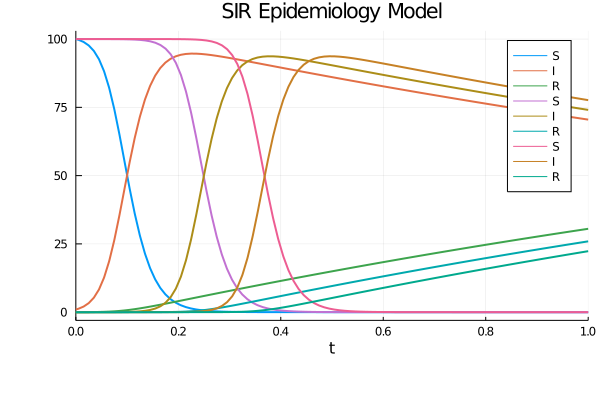

In [158]:
u0 = [100,1,0,100,0,0,100,0,0.0]
tspan = (0.0, 1.0)

prob = ODEProblem(threecity, u0, tspan)
sol = solve(prob, Tsit5(); dtmax = 0.01)

plot(sol, lw=2, title = "SIR Epidemiology Model", bottom_margin=10mm, left_margin=10mm, 
    label=["S" "I" "R"])

# Cellular Automata

DiscreteMachine(ℝ^100 × ℝ^2 → ℝ^100)

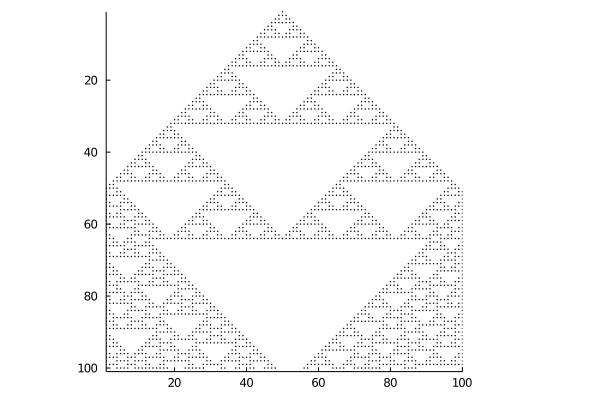

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range


In [159]:
function Rule(k::Int)
    (left_neighbor, x, right_neighbor) -> 
    Bool(digits(k, base=2, pad=8)[1 + right_neighbor + 2*x + 4*left_neighbor])
end

# Define the composition pattern
n = 100
row = apex(gridpath(n, 1))

# Define the primitive system
rule = DiscreteMachine{Bool}(2, 1, 2, (u, x, p, t)->Rule(p)(x[2], u[1], x[1]), 
            u->[u[1], u[1]])

# Compose
automata = oapply(row, rule)

# Solve and plot
u0 = zeros(Int, n); u0[Int(n/2)] = 1

rule_number = 126
traj = trajectory(automata, u0, [0,0], rule_number, 100)

spy(Matrix(traj))